# Hidden Markov Model 
<i> M2 MVA - ENS Cachan - Chia-Man Hung

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the data

In [2]:
data = pd.read_csv("classification_data_HWK3/EMGaussian.data", header=None, delim_whitespace=True)
n_data = data.shape[0]
test = pd.read_csv("classification_data_HWK3/EMGaussian.test", header=None, delim_whitespace=True)
n_test= test.shape[0]
n_plot = 100
d = 2
K = 4

pi = np.ones((K)) * 1. / K

# means and covariance matrices taken from HW2
mu = np.matrix([[ 3.98121317, -3.05961285,  3.79952166, -2.03403942],
        [ 3.83987129, -3.53232769, -3.77488947,  4.17291863]])
sigma = np.array([[[  0.20837986,   0.2756848 ],
        [  0.2756848 ,  11.93990587]],

       [[  6.25331365,   6.06131602],
        [  6.06131602,   6.19286092]],

       [[  0.91179453,   0.05566795],
        [  0.05566795,   1.91265325]],

       [[  2.90590645,   0.20794411],
        [  0.20794411,   2.75676235]]])

In [3]:
data_to_2d_array = np.empty((n_data, d))
for i in range(n_data):
    for j in range(d):
        data_to_2d_array[i, j] = data[j][i]

In [4]:
test_to_2d_array = np.empty((n_test, d))
for i in range(n_test):
    for j in range(d):
        test_to_2d_array[i, j] = test[j][i]

In [5]:
A = np.matrix(np.zeros((K, K)))
for i in range(K):
    for j in range(K):
            A[i, j] = 1. / 6
    A[i, i] = 1. / 2

## Preliminaries

In [6]:
def logsumexp(v):
    """
    Log sum exponential computation
    
    Parameters
    ----------
    v: `numpy.array`, vector of negative integers
    
    Returns
    -------
    `float`, log(sum(exp(v)))
    """
    max_v = max(v)
    new_v = np.empty((len(v)))
    for i in range(len(v)):
        new_v[i] = v[i] - max_v
    return max_v + np.log(sum(np.exp(new_v)))

In [7]:
def lognormal(x, mu, sigma):
    """
    Parameters
    ----------
    x: `numpy.array`
    mu: `numpy.matrix`, a column matrix, same length as x
    sigma: `numpy.matrix`, positive definite matrix
    
    Returns
    -------
    `float`, log(Normal(x; mu, sigma))
    """
    d = len(x)
    x_temp = np.matrix(x.reshape(d, 1)) - mu
    sigma_inv = np.linalg.inv(sigma)
    return - 0.5 * d * np.log(2 * np.pi) - 0.5 * sum(np.log(np.linalg.eigvals(sigma))) - 0.5 * (x_temp.transpose() * sigma_inv * x_temp)[0, 0]

In [8]:
mu[:, 1]

matrix([[-3.05961285],
        [-3.53232769]])

In [9]:
lognormal(np.array([2, 1]), mu[:, 1], np.matrix(sigma[1]))

-4.4456696395505428

## Q1 + Q2: Alpha, Beta message passing, Filtering

$\alpha_{t+1}(q_{t+1}) = p(u_{t+1} | q_{t+1}) \sum_{q_t} p(q_{t+1} | q_t) \alpha_t(q_t)$ <br />
$\alpha_1(q_1) = p(u_1 | q_1) \pi (q_1)$ <br />
$log \alpha_{t+1}(q_{t+1}) = log p(u_{t+1} | q_{t+1}) + log \sum_{q_t} exp( log p(q_{t+1} | q_t) + log\alpha_t(q_t) )$ <br />

In [46]:
def log_alpha(data_array, K, pi, mu, sigma, A):
    n_data = len(data_array)
    log_alpha = np.zeros((n_data, K))
    log_alpha[0, :] = np.log(pi)
    for k in range(K):
        log_alpha[0, k] += lognormal(data_array[0, :], mu[:, k], np.matrix(sigma[k]))
    for i in range(1, n_data):
        for k in range(K):
            log_alpha[i, k] += lognormal(data_array[i, :], mu[:, k], np.matrix(sigma[k]))
            sum_log_A_alpha_array = np.zeros((K))
            for j in range(K):
                sum_log_A_alpha_array[j] = np.log(A[j, k]) + log_alpha[i - 1, j]
            log_alpha[i, k] += logsumexp(sum_log_A_alpha_array)
    return log_alpha

In [47]:
la = log_alpha(test_to_2d_array, K, pi, mu, sigma, A)
la

array([[ -188.00115697,    -3.82569032,   -43.99039401,   -20.50115881],
       [  -96.58317785,    -7.01567428,   -27.74616522,   -15.89849723],
       [  -12.49889092,   -39.60100562,   -14.24511171,   -23.26529723],
       ..., 
       [-2555.09373621, -2415.88023432, -2446.87159356, -2430.54907937],
       [-2618.37219448, -2420.50389377, -2464.51987963, -2441.97364735],
       [-2603.10809971, -2423.69693797, -2463.75208079, -2442.19780001]])

$\beta_t(q_t) = \sum_{q_{t+1}} p(q_{t+1} | q_t) p(u_{t+1} | q_{t+1}) \beta_{t+1}(q_{t+1})$ <br />
$\beta_T(q_T) = 1_K$ <br />

In [79]:
def log_beta(data_array, K, mu, sigma, A):
    n_data = len(data_array)
    log_beta = np.zeros((n_data, K))
    for i in range(n_data - 2, -1, -1):
        for k in range(K):
            sum_log_A_beta_array = np.zeros((K))
            for j in range(K):
                sum_log_A_beta_array[j] = np.log(A[k, j]) + lognormal(data_array[i + 1, :], mu[:, j], np.matrix(sigma[j])) + log_beta[i + 1, j]
            log_beta[i, k] = logsumexp(sum_log_A_beta_array)
    return log_beta

In [80]:
lb = log_beta(test_to_2d_array, K, mu, sigma, A)
lb

array([[-2420.96958249, -2419.87124766, -2420.96958248, -2420.96875058],
       [-2415.68709225, -2416.68140244, -2416.42132309, -2416.6812947 ],
       [-2411.35888548, -2411.35888548, -2411.35888548, -2410.26027319],
       ..., 
       [   -8.91531607,    -7.81670379,    -8.91531607,    -8.91531607],
       [   -4.29165646,    -3.19304419,    -4.29165646,    -4.2916564 ],
       [    0.        ,     0.        ,     0.        ,     0.        ]])

$p(u_1, ..., u_T) = \sum_{q_t} p(q_t, u_1, ..., u_T) = \sum_{q_t} \alpha_t(q_t) \beta_t(q_t)$

In [50]:
def log_likelihood(log_alpha, log_beta, K):
    log_sum_alpha_beta = np.zeros((K))
    for j in range(K):
        log_sum_alpha_beta[j] += log_alpha[0, j] + log_beta[0, j]
    return logsumexp(log_sum_alpha_beta)

In [51]:
ll = log_likelihood(la, lb, K)
ll

-2423.6969379593393

$\gamma_t(q_t) = p(q_t | u_1, ..., u_T) = \frac{\alpha_t(q_t) \beta_t(q_t)}{\sum_{q_t} \alpha_t(q_t) \beta_t(q_t)}$ <br />
$log p(q_t | u_1, ..., u_T) = log \alpha_t(q_t) + log \beta_t(q_t) - log p(u_1, ..., u_T)$

In [52]:
def log_gamma(n_compute, log_alpha, log_beta, K):
    ll = log_likelihood(log_alpha, log_beta, K)
    result = np.zeros((n_compute, K))
    for i in range(n_compute):
        for k in range(K):
            result[i, k] += log_alpha[i, k] + log_beta[i, k] - ll
    return result

In [53]:
lg = log_gamma(n_plot, la, lb, K)
gamma = np.exp(lg)

In [54]:
def plot_gamma(gamma, n_plot):
    f1, axarr1 = plt.subplots(2, sharex=True)
    axarr1[0].scatter(range(n_plot), gamma[:, 0])
    axarr1[0].set_title('$p(q_t = 1|u_1, ..., u_T)$')
    axarr1[1].scatter(range(n_plot), gamma[:, 1])
    axarr1[1].set_title('$p(q_t = 2|u_1, ..., u_T)$')

    f2, axarr2 = plt.subplots(2, sharex=True)
    axarr2[0].scatter(range(n_plot), gamma[:, 2])
    axarr2[0].set_title('$p(q_t = 3|u_1, ..., u_T)$')
    axarr2[1].scatter(range(n_plot), gamma[:, 3])
    axarr2[1].set_title('$p(q_t = 4|u_1, ..., u_T)$')

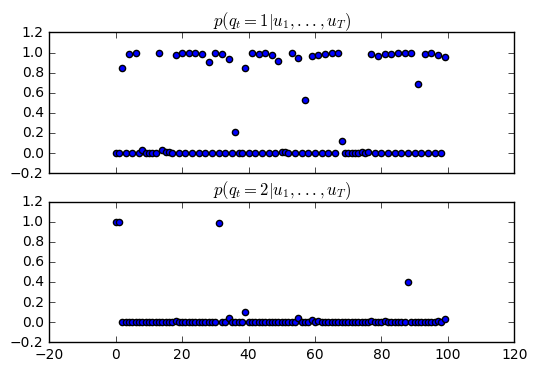

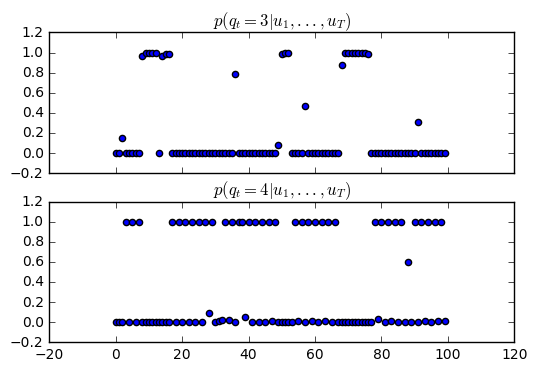

In [55]:
plot_gamma(gamma, n_plot)

$\xi_{t, t+1}^{i,j} = p(q_t = i, q_{t+1} = j | u_1, ..., u_T) = \frac{1}{p(u_1, ..., u_T)} \alpha_t(q_t = i) \beta_{t+1}(q_{t+1} = j) p(q_{t+1} = j | q_t = i) p(u_{t+1} | q_{t+1} = j)$

In [56]:
def log_xi(data_array, n_compute, log_alpha, log_beta, K):
    ll = log_likelihood(log_alpha, log_beta, K)
    result = np.zeros((K, K, n_compute))
    for t in range(n_compute):
        for i in range(K):
            for j in range(K):
                result[i, j, t] += - ll + log_alpha[t, i] + log_beta[t + 1, j] + np.log(A[i, j]) + lognormal(data_array[t + 1, :], mu[:, j], np.matrix(sigma[j])) 
    return result

In [57]:
lx = log_xi(test_to_2d_array, n_test - 1, la, lb, K)
xi = np.exp(lx)

## Q3 + Q4: EM-algorithm

$\pi_i^{(k)} = p(q_1 = i | u_1, ..., u_T; \theta^{(k-1)})$ <br />
$A_{i,j}^{(k)} = \frac{\sum_{t = 1}^{T-1} p(q_t = i, q_{t+1} = j | u_1, ..., u_T; \theta^{(k-1)})}{\sum_{t = 1}^{T-1}  p(q_t = i | u_1, ..., u_T; \theta^{(k-1)})}$ <br />
$\mu_i^{(k)} = \frac{\sum_{t = 1}^T u_t p(q_t = i | u_1, ..., u_T; \theta^{(k-1)})}{\sum_{t = 1}^T p(q_t = i | u_1, ..., u_T; \theta^{(k-1)})}$ <br />
$\Sigma_i^{(k)} = \frac{\sum_{t = 1}^T p(q_t = i | u_1, ..., u_T; \theta^{(k-1)}) (u_t - \mu_i^{(k)}) (u_t - \mu_i^{(k)})^T }{\sum_{t = 1}^T p(q_t = i | u_1, ..., u_T; \theta^{(k-1)})}$ <br />

In [58]:
def EM_HMM_iterate_once(data_array, K, d, pi_current, mu_current, sigma_current, A_current):
    n_data = len(data_array)
    la = log_alpha(data_array, K, pi_current, mu_current, sigma_current, A_current)
    lb = log_beta(data_array, K, mu_current, sigma_current, A_current)
    lg = log_gamma(n_data, la, lb, K)
    gamma = np.exp(lg)
    lx = log_xi(data_array, n_data - 1, la, lb, K)
    xi = np.exp(lx)
    
    pi_new = gamma[0]
    
    A_new = np.zeros((K, K))
    for i in range(K):
        for j in range(K):
            A_new[i, j] = sum(xi[i, j]) / sum(gamma[: n_data, i])
            
    mu_new = np.zeros((d, K))
    for i in range(K):
        numerator = np.zeros((d))
        denominator = 0
        for t in range(n_data):
            numerator += data_array[t, :] * gamma[t, i]
            denominator += gamma[t, i]
        mu_new[:, i] = numerator / denominator
    mu_new = np.matrix(mu_new)
        
    sigma_new = np.zeros((K, d, d))
    for i in range(K):
        numerator = np.zeros((d, d))
        denominator = 0
        for t in range(n_data):
            diff = np.matrix(data_array[t, :]) - mu_new[: , i]
            numerator += diff.transpose() * diff * gamma[t, i]
            denominator += gamma[t, i]
        sigma_new[i, :, :] = numerator / denominator
    
    return pi_new, mu_new, sigma_new, A_new

In [59]:
pi_new, mu_new, sigma_new, A_new = EM_HMM_iterate_once(data_to_2d_array, K, d, pi, mu, sigma, A)

In [60]:
pi_new

array([  5.24489725e-10,   9.58814012e-01,   6.92901981e-04,
         4.04930851e-02])

In [61]:
A_new

array([[ 0.06116227,  0.05872033,  0.01577716,  0.86434024],
       [ 0.07523675,  0.87223277,  0.03328385,  0.01277939],
       [ 0.04582094,  0.03106549,  0.77348572,  0.14962784],
       [ 0.77385603,  0.0686121 ,  0.12200173,  0.03552826]])

In [62]:
mu_new

matrix([[ 3.99647315, -2.99973801,  3.79876952, -2.01807801],
        [ 4.16386539, -3.47176615, -3.70432189,  4.19789121]])

In [63]:
sigma_new

array([[[  0.42844815,   0.42055684],
        [  0.42055684,  20.73547716]],

       [[ 13.26957266,  12.65669721],
        [ 12.65669721,  13.14146144]],

       [[ 58.04280877,   0.11446576],
        [  0.11446576,  60.34166851]],

       [[ 44.72963209,   0.57736294],
        [  0.57736294,  44.06376063]]])

In [64]:
def EM_HMM_iterate(data_array, K, d, pi_current, mu_current, sigma_current, A_current, n_iteration):
    pi_before, mu_before, sigma_before, A_before = pi_current, mu_current, sigma_current, A_current
    for j in range(n_iteration):
        pi_after, mu_after, sigma_after, A_after = EM_HMM_iterate_once(data_array, K, d, pi_before, mu_before, sigma_before, A_before)
        pi_before, mu_before, sigma_before, A_before = pi_after, mu_after, sigma_after, A_after
    return pi_before, mu_before, sigma_before, A_before

In [65]:
pi_2, mu_2, sigma_2, A_2 = EM_HMM_iterate(data_to_2d_array, K, d, pi, mu, sigma, A, 2)

In [66]:
pi_2

array([  1.16941414e-12,   9.85623962e-01,   8.43355349e-04,
         1.35326826e-02])

In [67]:
mu_2

matrix([[ 3.97794528, -2.93888432,  3.65265712, -1.00805497],
        [ 2.16946641, -3.41668188, -3.90800293,  2.75136965]])

In [68]:
sigma_2

array([[[  3.7946563 ,   0.5986876 ],
        [  0.5986876 ,  41.09005033]],

       [[ 14.07485823,  13.41737769],
        [ 13.41737769,  13.87368845]],

       [[ 61.82816268,  -1.42955959],
        [ -1.42955959,  64.70545125]],

       [[ 28.90608314, -11.95633089],
        [-11.95633089,  39.0049783 ]]])

In [69]:
A_2

array([[  0.35770404,   0.10052522,   1.28277274,   1.16859483],
       [  0.2121426 ,   0.85275729,   0.42677227,   0.46566066],
       [  0.25609675,   0.14222683,  10.5602272 ,   0.21457879],
       [  0.21890016,   0.2567313 ,   0.67774894,   1.87749861]])

## Q5: Log-likelihood

In [70]:
def log_likelihood_data(data_array, K, pi, mu, sigma, A):
    la = log_alpha(data_array, K, pi, mu, sigma, A)
    lb = log_beta(data_array, K, mu, sigma, A)
    return log_likelihood(la, lb, K)

In [85]:
log_likelihood_data(data_to_2d_array, K, pi, mu, sigma, A)

-2299.2335709386371

In [84]:
log_likelihood_data(data_to_2d_array, K, pi_new, mu_new, sigma_new, A_new)

-2426.9933401249164

In [83]:
log_likelihood_data(data_to_2d_array, K, pi_2, mu_2, sigma_2, A_2)

-2018.6093965628768

In [72]:
def EM_log_likelihood(train_array, test_array, K, d, pi_current, mu_current, sigma_current, A_current, n_iteration):
    train_result = []
    test_result = []
    
    pi_before, mu_before, sigma_before, A_before = pi_current, mu_current, sigma_current, A_current
    
    train_result.append(log_likelihood_data(train_array, K, pi_before, mu_before, sigma_before, A_before))
    test_result.append(log_likelihood_data(test_array, K, pi_before, mu_before, sigma_before, A_before))
    
    for j in range(n_iteration):
        pi_after, mu_after, sigma_after, A_after = EM_HMM_iterate_once(train_array, K, d, pi_before, mu_before, sigma_before, A_before)
        
        train_result.append(log_likelihood_data(train_array, K, pi_after, mu_after, sigma_after, A_after))
        test_result.append(log_likelihood_data(test_array, K, pi_after, mu_after, sigma_after, A_after))
        
        pi_before, mu_before, sigma_before, A_before = pi_after, mu_after, sigma_after, A_after
        
    return train_result, test_result

In [73]:
train_ll, test_ll = EM_log_likelihood(data_to_2d_array, test_to_2d_array, K, d, pi, mu, sigma, A, 3)

In [74]:
train_ll

[-2299.2335709386371,
 -2426.9933401249164,
 -2018.6093965628768,
 -2713.8382664328742]

In [75]:
test_ll

[-2423.6969379593393,
 -2517.383125114648,
 -2039.1259480093661,
 -2892.763343982986]

In [76]:
n_iter = 10
X = range(n_iter + 1)
Y_train, Y_test = EM_log_likelihood(data_to_2d_array, test_to_2d_array, K, d, pi, mu, sigma, A, n_iteration=n_iter)

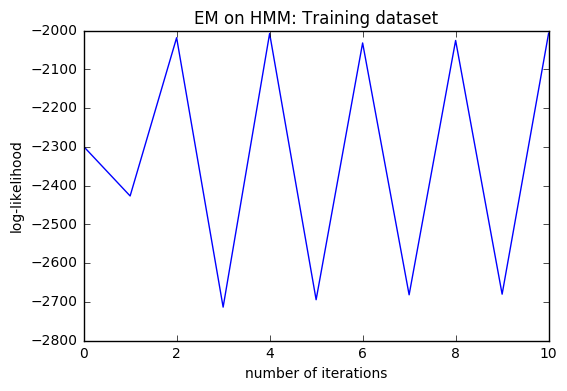

In [77]:
plt.xlabel("number of iterations")
plt.ylabel("log-likelihood")
plt.title("EM on HMM: Training dataset")
plt.plot(X, Y_train)
plt.show()

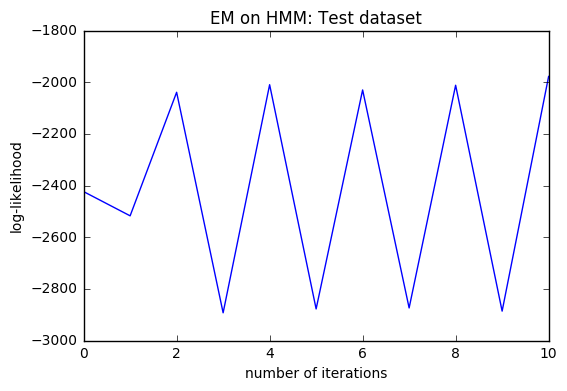

In [78]:
plt.xlabel("number of iterations")
plt.ylabel("log-likelihood")
plt.title("EM on HMM: Test dataset")
plt.plot(X, Y_test)
plt.show()

## Q6: Comparison between Gaussian Mixture Model and HMM

## Q7 + Q8: Viterbo decoding algorithm (aka max-product algorithm)

## Q9: Filtering computed from the learnt parameters in Q4

## Q10: Plot of the most likely states from Q9

## Q11: Viterbo on the test data / Most likely states